In [1]:
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

In [2]:
import yaml, matplotlib, random, pickle, time
import numpy as np
import pandas as pd
from glob import glob
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import morlet2, cwt
from sklearn.mixture import GaussianMixture

from helper import _rotational, angle_calc

# Start Analysis

In [3]:
with open("config.yaml") as f:
    config = yaml.load(f, Loader=yaml.FullLoader)

In [5]:
# Initialize
files_ref, bad_frames_ref = {}, {}
frame_start = 0
bp_list, scale_list, angles_list, power_list = [], [], [], []

# Bodypoints Used for Analysis
bp_analyze = []
for angle_points in config["angles"]:
    bp_analyze.extend(angle_points.values())
bp_analyze.append(config["bp_rotate"])
bp_analyze.extend(config["bp_scale"])
bp_analyze.append(config["bp_center"])
bp_analyze = np.unique(bp_analyze)

for path in tqdm(glob(f"{config['input_data_path']}/**/*.h5")):
    # Import
    store = pd.HDFStore(path, mode='a')
    df = store['df_with_missing']
    x_data = df.xs('x', level="coords", axis=1).to_numpy()
    y_data = df.xs('y', level="coords", axis=1).to_numpy()
    likelihood = df.xs('likelihood', level="coords", axis=1).to_numpy()
    store.close()
    
    # Check Likelihood
    below_thresh = np.where(likelihood[:, bp_analyze] < .2)
    fr_bad = np.unique(below_thresh[0])
    bad_frames_ref[path] = fr_bad

    # Center
    x_center = x_data[:,config['bp_center']]
    y_center = y_data[:,config['bp_center']]
    x_data -= x_center[:,np.newaxis]
    y_data -= y_center[:,np.newaxis]
        
    # Format
    DLC_data = np.concatenate((
        np.expand_dims(x_data, axis=-1), 
        np.expand_dims(y_data, axis=-1)), axis=-1)
    num_fr,_,_ = DLC_data.shape
    
    # Scale
    x_d = DLC_data[:,config['bp_scale'][0],0] - DLC_data[:,config['bp_scale'][1],0]
    y_d = DLC_data[:,config['bp_scale'][0],1] - DLC_data[:,config['bp_scale'][1],1]
    dist = np.sqrt(x_d**2+y_d**2)
    norm = np.median(dist)
    scale_list.append(norm)
    DLC_data /= norm

    # Rotate
    ROT_data, body_angle = _rotational(data=DLC_data, axis_bp=config['bp_rotate'])
    bp_list.append(ROT_data)

    # Angles
    angles = angle_calc(ROT_data, config['angles'])
    angles -= np.mean(angles, axis=0)
    angles_list.append(angles)

    # Record Files
    files_ref[path] = (frame_start, frame_start+num_fr)
    frame_start += num_fr

# Combine Bodypoints and Angles Data
tot_bp = np.concatenate(bp_list, axis=0)
tot_angles = np.concatenate(angles_list, axis=0)  

for angles in angles_list:
    # Normalize Angles
    angles -= np.mean(tot_angles, axis=0)
    
    # Morlet Wavelet
    num_fr, num_ang = angles.shape
    power = np.zeros((num_ang, config['f_bin'], num_fr))
    max_freq, min_freq = config['fps']/2, 1 # Nyquist Frequency
    freq = max_freq*2**(-1*np.log2(max_freq/min_freq)*
        (np.arange(config['f_bin'],0,-1)-1)/(config['f_bin']-1))
    widths = config['w']*config['fps'] / (2*freq*np.pi)
    
    # Normalization Factor
    s = (config['w'] + np.sqrt(2+config['w']**2))/(4*np.pi*freq)
    C = np.pi**(-0.25)*np.exp(0.25*(config['w']-np.sqrt(config['w']**2+2))**2)/np.sqrt(2*s)

    for i in range(num_ang):
        cwtm = cwt(angles[:,i], morlet2, widths, dtype=None, w=config['w'])
        # power[i] = np.abs(cwtm)**2
        power[i] = (np.abs(cwtm/np.expand_dims(np.sqrt(s),1)))/np.expand_dims(C, axis=(0,2))
    power_list.append(power)

tot_pwr = np.concatenate(power_list, axis=2)

# Take Out Bad Frames
tot_fr_bad = []
for path, fr_range in files_ref.items():
    tot_fr_bad.extend(bad_frames_ref[path]+fr_range[0])
good_tot_pwr = np.delete(tot_pwr, tot_fr_bad, axis=2).shape

# Dimensional Reduction
num_angles, num_freq, num_good_fr = good_tot_pwr.shape
power_mod = good_tot_pwr.reshape((num_angles*num_freq, num_good_fr)).T

(88, 30)
(88, 30)
(7051, 30)
(7051, 30)
(1666, 30)
(1666, 30)
(1974, 30)
(1974, 30)
(2962, 30)
(2962, 30)
(3442, 30)
(3442, 30)
(694, 30)
(694, 30)
(1411, 30)
(1411, 30)
(479, 30)
(479, 30)
(831, 30)
(831, 30)
(3702, 30)
(3702, 30)
(1241, 30)
(1241, 30)
(1966, 30)
(1966, 30)
(326, 30)
(326, 30)
(841, 30)
(841, 30)
(1309, 30)
(1309, 30)
(1613, 30)
(1613, 30)
(811, 30)
(811, 30)
(395, 30)
(395, 30)
(827, 30)
(827, 30)
(191, 30)
(191, 30)
(1102, 30)
(1102, 30)
(1228, 30)
(1228, 30)
(792, 30)
(792, 30)
(1653, 30)
(1653, 30)
(477, 30)
(477, 30)
(2680, 30)
(2680, 30)
(580, 30)
(580, 30)
(1284, 30)
(1284, 30)
(6347, 30)
(6347, 30)
(324, 30)
(324, 30)
(202, 30)
(202, 30)
(1165, 30)
(1165, 30)
(405, 30)
(405, 30)
(1387, 30)
(1387, 30)
(2074, 30)
(2074, 30)
(354, 30)
(354, 30)
(889, 30)
(889, 30)
(1733, 30)
(1733, 30)
(179, 30)
(179, 30)
(609, 30)
(609, 30)
(249, 30)
(249, 30)
(628, 30)
(628, 30)
(3920, 30)
(3920, 30)
(776, 30)
(776, 30)
(779, 30)
(779, 30)
(715, 30)
(715, 30)
(1251, 30)
(1251, 

In [18]:
tot_pwr.shape

(2, 20, 76526)

(2, 20, 75463)

In [20]:
76526-len(tot_fr_bad)

75463

In [5]:
filename = "data/clean_data/maj_20181101_XX_trail2_7933-14983/maj_20181101_XX_trail2_7933-14983DeepCut_resnet50_small_arenaJun18shuffle1_1030000.h5"

# Import
store = pd.HDFStore(filename, mode='a')
df = store['df_with_missing']
x_data = df.xs('x', level="coords", axis=1).to_numpy()
y_data = df.xs('y', level="coords", axis=1).to_numpy()
likelihood = df.xs('likelihood', level="coords", axis=1).to_numpy()
store.close()

# Bodypoints Used for Analysis
bp_analyze = []
for angle_points in config["angles"]:
    bp_analyze.extend(angle_points.values())
bp_analyze.append(config["bp_rotate"])
bp_analyze.extend(config["bp_scale"])
bp_analyze.append(config["bp_center"])
bp_analyze = np.unique(bp_analyze)

# Check Likelihood
below_thresh = np.where(likelihood[:, bp_analyze] < .2)
fr_bad = np.unique(below_thresh[0])
print(path)
print(bp_analyze[below_thresh[1]])

# Center
x_center = x_data[:,config['bp_center']]
y_center = y_data[:,config['bp_center']]
x_data -= x_center[:,np.newaxis]
y_data -= y_center[:,np.newaxis]

# Format
DLC_data = np.concatenate((
    np.expand_dims(x_data, axis=-1), 
    np.expand_dims(y_data, axis=-1)), axis=-1)

# Scale
x_d = DLC_data[:,config['bp_scale'][0],0] - DLC_data[:,config['bp_scale'][1],0]
y_d = DLC_data[:,config['bp_scale'][0],1] - DLC_data[:,config['bp_scale'][1],1]
dist = np.sqrt(x_d**2+y_d**2)
norm = np.median(dist)
scale_list.append(norm)
DLC_data /= norm

# Rotate
ROT_data, body_angle = _rotational(data=DLC_data, axis_bp=config['bp_rotate'])
bp_list.append(ROT_data)

# Angles
angles = angle_calc(ROT_data, config['angles'])
angles -= np.mean(angles, axis=0)
angles_list.append(angles)

data/clean_data/mid_20181018_ant5_food2_2458-2940/mid_20181018_ant5_food2_2458-2940DeepCut_resnet50_small_arenaJun18shuffle1_1030000.h5
[ 951  952  952  953  954  956  958  960  962  963  963  964  993 1023
 1023 1024 1024 1025 1025 1026 1028 1029 1030 1031 1242 1243 1339 1344
 1385 1386 1387 1388 1388 1390 1391 1391 1392 1393 1394 1423 1424 1424
 1433 1434 1442 1443 1444 1445 1446 1484 1485 1486 1501 1505 1507 1508
 1509 1509 1510 1510 1511 1512 1514 1541 1542 1542 1543 1567 1568 1569
 1573 1574 1575 1607 1608 1609 1609 1610 1610 1611 1611 1612 1612 1613
 1614 1615 1616 1617 1619 1619 1620 1651 1685 1686 1689 1695 1697 1698
 1699 1700 1700 1701 1701 1702 1702 1703 1703 1704 1704 1705 1705 1706
 1706 1707 1707 1708 1709 1710 1711 1712 1712 1713 1714 1715 1716 1717
 1718 1719 1720 1721 1723 1724 1725 1726 1727 1728 1729 1730 1731 1732
 1733 1734 1735 1736 1738 1739 1740 1741 1742 1743 1744 1745 1746 1747
 1748 1749 1750 1751 1752 1753 1754 1755 1756 1757 1758 1759 1760 1761
 1762 1763 1

In [220]:
len(np.where(likelihood[:, bp_analyze] < .5)[0])

545

In [199]:
DLC_data.shape

(7051, 30, 2)

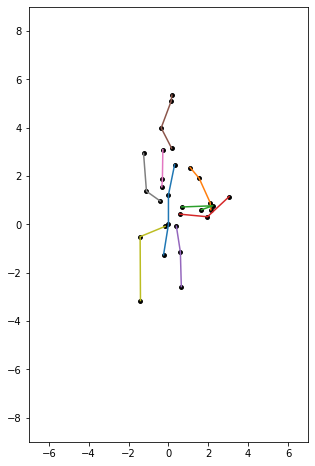

In [232]:
frame=3060

fig, ax = plt.subplots(figsize=(5,8))
ax.scatter(ROT_data[frame,:,0], ROT_data[frame,:,1], s=15, c='k')
plt.plot(ROT_data[frame,0:4,0], ROT_data[frame,0:4,1])
plt.plot(ROT_data[frame,4:8,0], ROT_data[frame,4:8,1])
plt.plot(ROT_data[frame,8:11,0], ROT_data[frame,8:11,1])
plt.plot(ROT_data[frame,11:14,0], ROT_data[frame,11:14,1])
plt.plot(ROT_data[frame,14:17,0], ROT_data[frame,14:17,1])
plt.plot(ROT_data[frame,17:21,0], ROT_data[frame,17:21,1])
plt.plot(ROT_data[frame,21:24,0], ROT_data[frame,21:24,1])
plt.plot(ROT_data[frame,24:27,0], ROT_data[frame,24:27,1])
plt.plot(ROT_data[frame,27:30,0], ROT_data[frame,27:30,1])
ax.set(xlim=(-7,7), ylim=(-9,9))
plt.show()

In [ ]:
for angles in angles_list:
    # Normalize Angles
    angles -= np.mean(tot_angles, axis=0)
    # Morlet Wavelet
    num_fr, num_ang = angles.shape
    power = np.zeros((num_ang, config['f_bin'], num_fr))
    max_freq, min_freq = config['fps']/2, 1 # Nyquist Frequency
    freq = max_freq*2**(-1*np.log2(max_freq/min_freq)*
        (np.arange(config['f_bin'],0,-1)-1)/(config['f_bin']-1))
    widths = config['w']*config['fps'] / (2*freq*np.pi)
    # Normalization Factor
    s = (config['w'] + np.sqrt(2+config['w']**2))/(4*np.pi*freq)
    C = np.pi**(-0.25)*np.exp(0.25*(config['w']-np.sqrt(config['w']**2+2))**2)/np.sqrt(2*s)
    for i in range(num_ang):
        cwtm = cwt(angles[:,i], morlet2, widths, dtype=None, w=config['w'])
        power[i] = (np.abs(cwtm)**2)
#         power[i] = np.abs(cwtm/np.expand_dims(np.sqrt(s),1))
        power[i] = (np.abs(cwtm/np.expand_dims(np.sqrt(s),1)))/np.expand_dims(C, axis=(0,2))
    power_list.append(power)

tot_pwr = np.concatenate(power_list, axis=2)

In [128]:
min_trail, min_food, min_free = 0,0,0
mid_trail, mid_food, mid_free = 0,0,0
maj_trail, maj_food, maj_free = 0,0,0

for key, fr_range in files_ref.items():
    # Caste Condition
    if key.find("min_") is not -1:
        # Environmental Conditions
        if key.find("trail") is not -1:
            min_trail += fr_range[1]-fr_range[0]
        if key.find("food") is not -1:
            min_food += fr_range[1]-fr_range[0]
        if key.find("free") is not -1:
            min_free += fr_range[1]-fr_range[0]
    
    if key.find("mid_") is not -1:
        caste_data["mid"].extend(range(fr_range[0], fr_range[1]))
        # Environmental Conditions
        if key.find("trail") is not -1:
            mid_trail += fr_range[1]-fr_range[0]
        if key.find("food") is not -1:
            mid_food += fr_range[1]-fr_range[0]
        if key.find("free") is not -1:
            mid_free += fr_range[1]-fr_range[0]
            
    if key.find("maj_") is not -1:
        caste_data["maj"].extend(range(fr_range[0], fr_range[1]))
        # Environmental Conditions
        if key.find("trail") is not -1:
            maj_trail += fr_range[1]-fr_range[0]
        if key.find("food") is not -1:
            maj_food += fr_range[1]-fr_range[0]
        if key.find("free") is not -1:
            maj_free += fr_range[1]-fr_range[0]
    
    

In [145]:
76526/50/60

25.508666666666667

In [144]:
tot_pwr.shape

(2, 20, 76526)